In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [12]:
data = []
file_name = []
datalabel = []
path = []
data_distribution = {}

for label in os.listdir("dataset"):
    label_path = os.path.join("dataset", label)
    if not os.path.isdir(label_path):
        continue
    images = os.listdir(label_path)
    data_distribution[label] = len(images)
    print(f"Memproses label: {label}, jumlah gambar: {len(images)}")

    for filename in images:
        img_path = os.path.join(label_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (350, 350))
            data.append(img)
            datalabel.append(label)  
            file_name.append(filename)
            path.append(img_path)

print("Data: ", len(data))
print("Label: ", len(datalabel))
print("Filenames: ", len(file_name))
print("Data Distribution: ", data_distribution)


Memproses label: fresh, jumlah gambar: 72
Memproses label: spoiled, jumlah gambar: 72
Data:  144
Label:  144
Filenames:  144
Data Distribution:  {'fresh': 72, 'spoiled': 72}


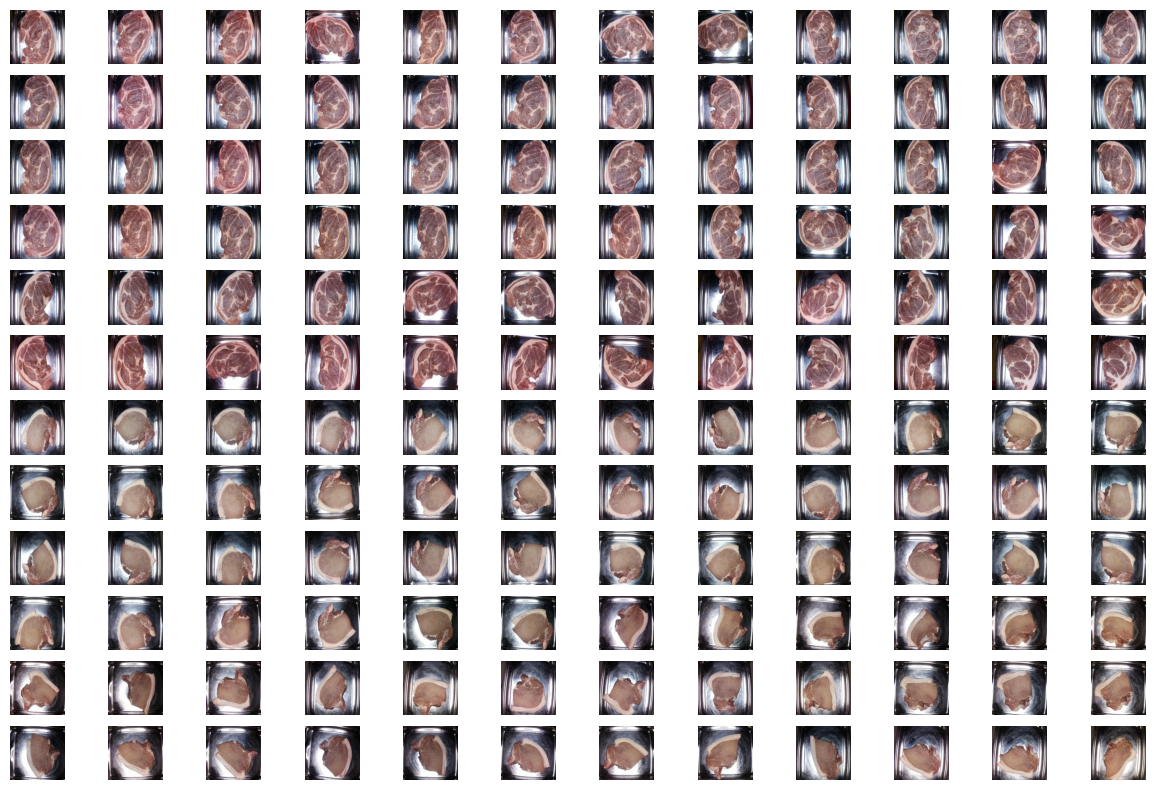

In [13]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(15, 10))
    for i in range(1, row * column + 1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i - 1], cmap='gray')
        plt.axis('off')  
    plt.show()
displayImg(12,12, data)

## Data Augmentation

### Define Augmentation Function


In [14]:
data_augmented = [] 
labels_augmented = []
file_name_augmented = []

def flip_horizontal(image):
    return np.fliplr(image)

def rotate(image):
    return np.rot90(image, k=3)  

for i in range(len(data)):
    original = data[i]
    flipped = flip_horizontal(original)
    rotated = rotate(original)

    data_augmented.extend([flipped, rotated])
    labels_augmented.extend([datalabel[i]] * 2)
    file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])

print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(data_augmented))


Jumlah data sebelum augmentasi: 144
Jumlah data setelah augmentasi: 288


## Data Preparation

### Define Preprocessing Function


In [15]:
# def resize(image, new_width, new_height):
#     old_height, old_width = image.shape[:2]
#     resized_image = np.zeros((new_height, new_width), dtype=np.uint8)

#     for i in range(new_height):
#         for j in range(new_width):
#             x = int(j * old_width / new_width)
#             y = int(i * old_height / new_height)
#             resized_image[i, j] = image[y, x]

#     return resized_image

# def equalization(image):
#     equ = cv.equalizeHist(gray)
#     return equ

gray = cv.cvtColor(data[0], cv.COLOR_RGB2GRAY)


def equalization(image):
    frequent = {}
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value in frequent:
                frequent[value] += 1
            else:
                frequent[value] = 1

    cumuFreq = {}
    sortedKey = sorted(frequent.keys())
    
    total = 0
    for key in sortedKey:
        total += frequent[key]
        cumuFreq[key] = total

    newPixel = {}
    sumAllPixel = image.shape[0] * image.shape[1]
    for key in sortedKey:
        newPixel[key] = round((cumuFreq[key] / sumAllPixel) * 255)

    newImage = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            newImage[i, j] = newPixel[image[i, j]]

    return newImage
    
def sobel(gray):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[ 1,  2,  1],
                        [ 0,  0,  0],
                        [-1, -2, -1]])

    tinggi, lebar = gray.shape
    hasil = np.zeros((tinggi, lebar), dtype=np.float32)

    for i in range(1, tinggi-1):
        for j in range(1, lebar-1):
            region = gray[i-1:i+2, j-1:j+2]
            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)
            hasil[i, j] = np.sqrt(gx**2 + gy**2)

    hasil = np.clip(hasil, 0, 255)
    return hasil.astype(np.uint8)


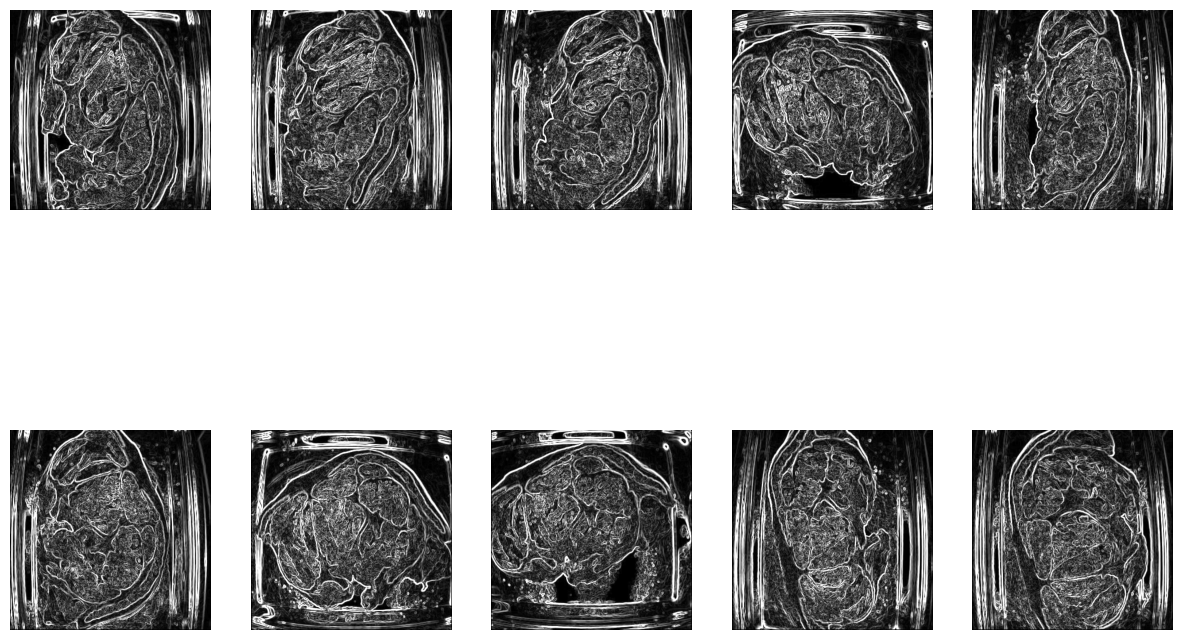

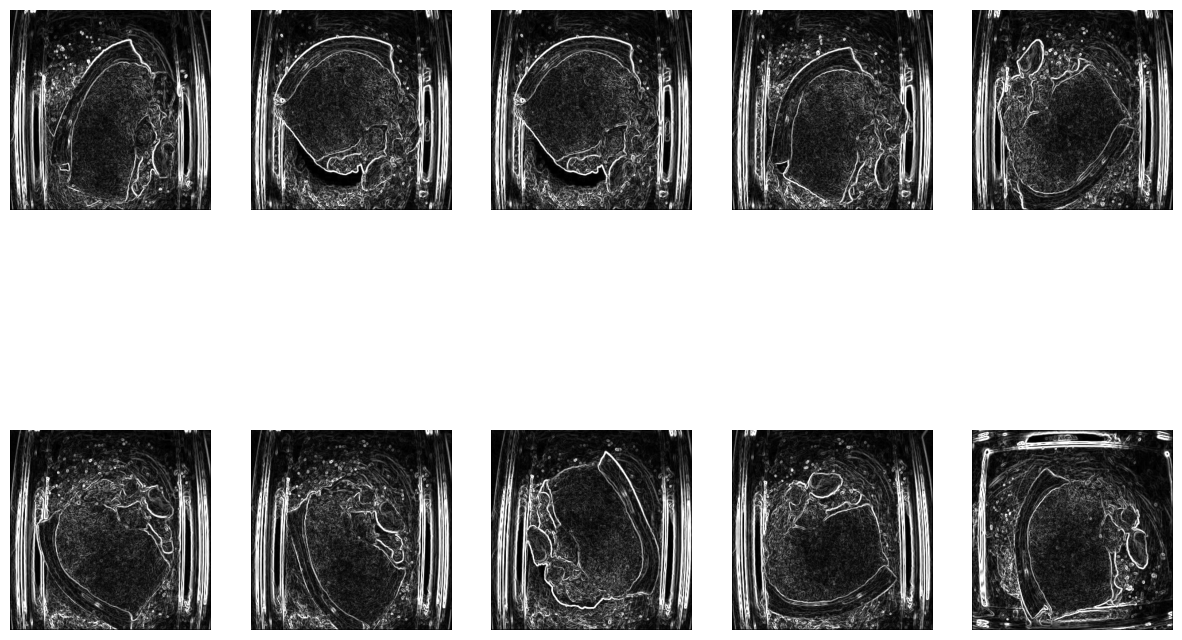

In [16]:
fresh_images = []
spoiled_images = []

for i in range(len(data)):
    if datalabel[i].lower() == 'fresh' and len(fresh_images) < 10:
        gray = cv.cvtColor(data[i], cv.COLOR_RGB2GRAY)
        edge = sobel(gray)
        fresh_images.append(edge)
    elif datalabel[i].lower() == 'spoiled' and len(spoiled_images) < 10:
        gray = cv.cvtColor(data[i], cv.COLOR_RGB2GRAY)
        edge = sobel(gray)
        spoiled_images.append(edge)
    
    if len(fresh_images) >= 10 and len(spoiled_images) >= 10:
        break

displayImg(2, 5, fresh_images)
displayImg(2, 5, spoiled_images)


### Preprocessing

In [17]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)):
    img = cv.resize(data[i], (128, 128))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  
    img = equalization(img)
    dataPreprocessed.append(img)


### Feature Extraction

In [18]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [19]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [20]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [21]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [22]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [23]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [24]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

In [25]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())


In [26]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [27]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [28]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [29]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [30]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [31]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [32]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [33]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [34]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [36]:
dataTable = {'Filename': file_name, 'Label': datalabel,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,08-11-2022-09-29-23_jpg.rf.64d249dc62a73d0ad8a...,fresh,1320.178088,1638.722673,620.647884,1538.615723,0.088009,0.079544,0.171249,0.080163,...,0.000399,0.000184,0.014212,0.013667,0.019983,0.013581,0.877148,0.846878,0.942436,0.856240
1,08-11-2022-09-31-38_jpg.rf.a062a431d30171b3151...,fresh,1460.144131,1766.174468,585.751722,1611.075702,0.086610,0.072591,0.156492,0.082823,...,0.000239,0.000128,0.011479,0.010784,0.015471,0.011300,0.864495,0.835667,0.945750,0.850092
2,08-11-2022-09-33-12_jpg.rf.b59993e6f78e188270c...,fresh,1423.048967,1689.826276,523.008920,1515.613739,0.087840,0.073538,0.153391,0.081668,...,0.000239,0.000128,0.011573,0.010986,0.015468,0.011326,0.868418,0.843602,0.951653,0.859725
3,08-11-2022-09-33-46_jpg.rf.ac147752030f7341361...,fresh,881.788201,1283.191828,844.806779,1422.232438,0.129028,0.097702,0.127759,0.091619,...,0.000382,0.000292,0.020387,0.017602,0.019552,0.017090,0.918263,0.880458,0.921671,0.867507
4,08-11-2022-09-38-25_jpg.rf.98422f41a439f4b9caf...,fresh,1252.216597,1419.719449,346.747662,1283.879348,0.093567,0.080865,0.175613,0.087224,...,0.000313,0.000157,0.012765,0.012277,0.017703,0.012528,0.884350,0.868554,0.967902,0.881129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,08-11-2022-22-04-53_jpg.rf.898d4dacb6b481c54a1...,spoiled,642.472687,1075.410999,645.941375,1008.611941,0.151733,0.103971,0.146780,0.115155,...,0.000531,0.000441,0.023887,0.020449,0.023047,0.021006,0.940374,0.900188,0.940402,0.906388
140,08-11-2022-22-05-41_jpg.rf.1911a77bc56f9cf0c0d...,spoiled,1109.584092,1189.619629,207.507751,1169.626387,0.117448,0.108043,0.192161,0.100420,...,0.000471,0.000240,0.016231,0.015940,0.021704,0.015498,0.897392,0.889792,0.980755,0.891651
141,08-11-2022-22-06-09_jpg.rf.22c8c2df12f95b3ce32...,spoiled,1261.642594,1431.903218,338.523068,1358.585715,0.104320,0.099772,0.158943,0.086599,...,0.000273,0.000150,0.013068,0.012548,0.016522,0.012253,0.883514,0.867415,0.968626,0.874213
142,08-11-2022-22-06-15_jpg.rf.a281f03d8553c96d251...,spoiled,1327.733883,1537.922500,375.467151,1429.816108,0.105100,0.091648,0.157875,0.087137,...,0.000263,0.000150,0.012823,0.012218,0.016227,0.012243,0.877373,0.857548,0.965196,0.867571


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

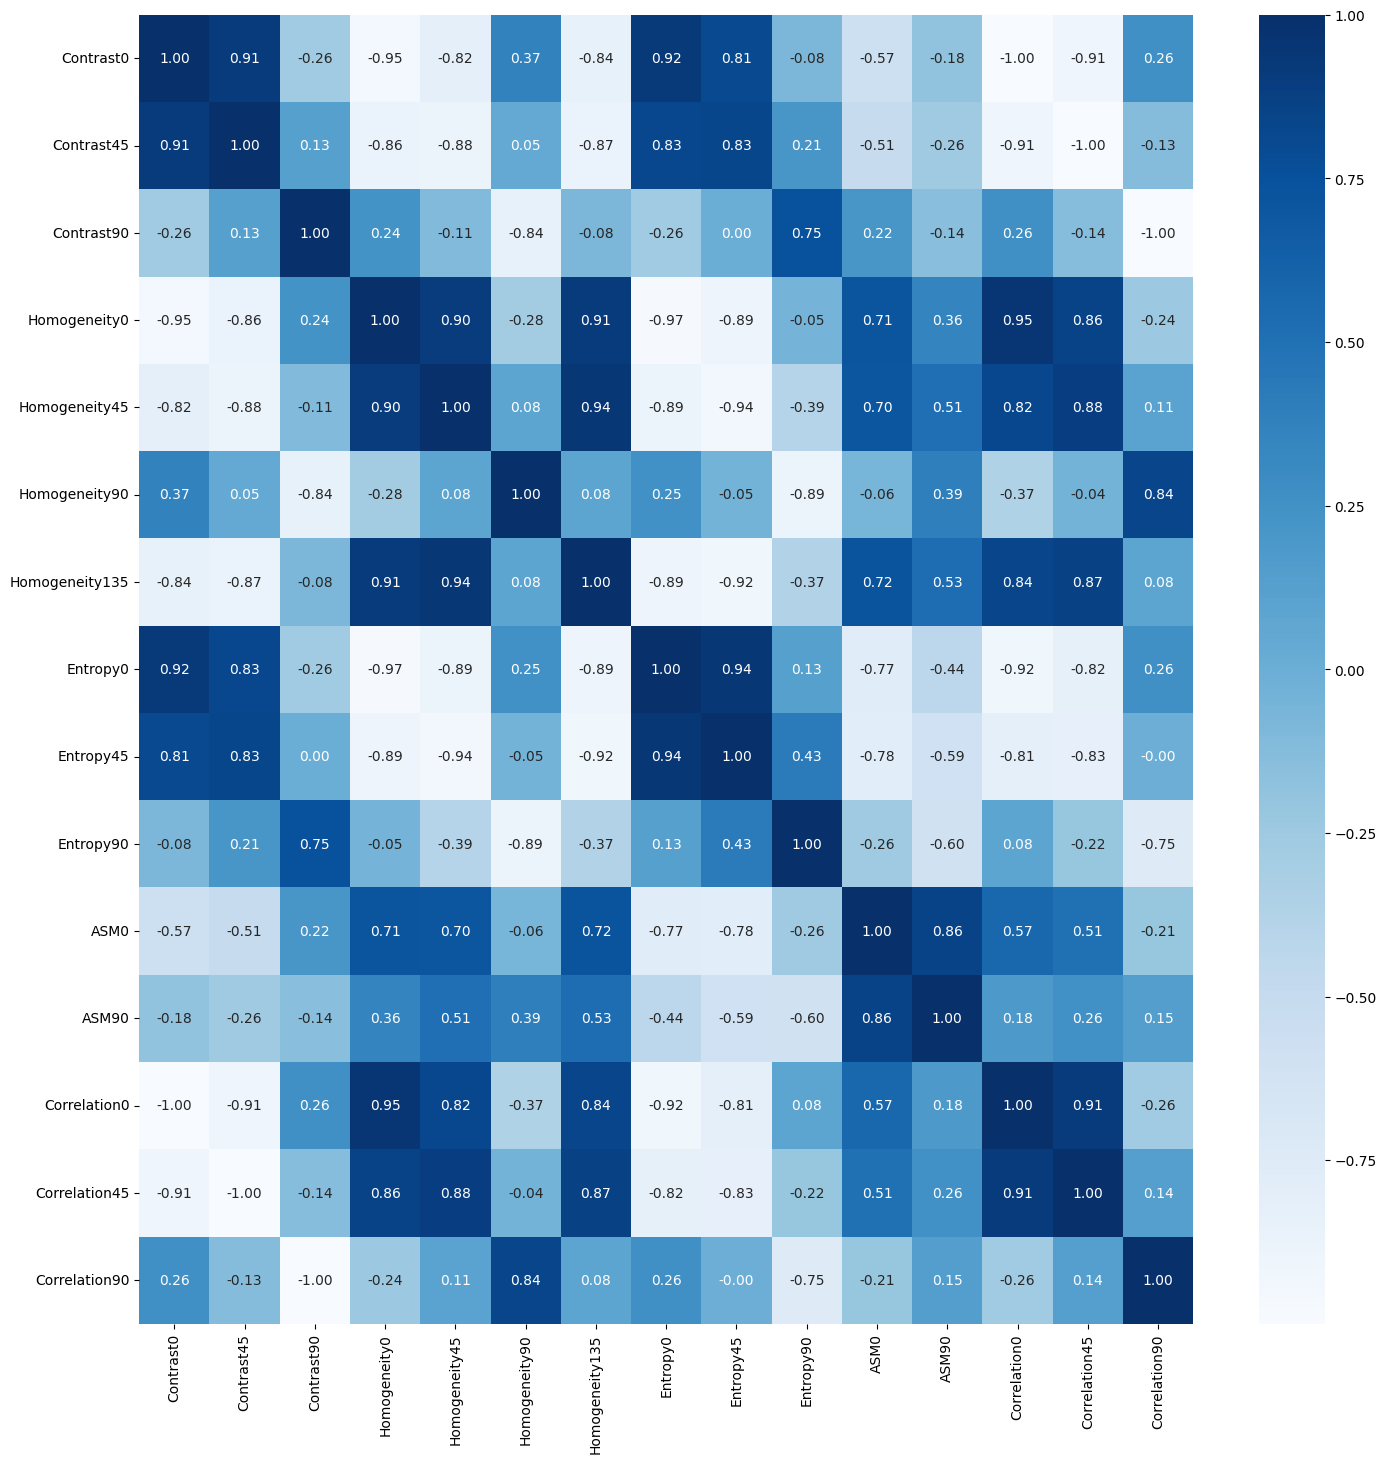

In [37]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [38]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(115, 15)
(29, 15)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [41]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [42]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [43]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       0.98      0.96      0.97        56
     spoiled       0.97      0.98      0.97        59

    accuracy                           0.97       115
   macro avg       0.97      0.97      0.97       115
weighted avg       0.97      0.97      0.97       115

[[54  2]
 [ 1 58]]
Accuracy: 0.9739130434782609

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.88      0.93        16
     spoiled       0.87      1.00      0.93        13

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29

[[14  2]
 [ 0 13]]
Accuracy: 0.9310344827586207


### Train SVM Classifier

In [44]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.91      0.93      0.92        56
     spoiled       0.93      0.92      0.92        59

    accuracy                           0.92       115
   macro avg       0.92      0.92      0.92       115
weighted avg       0.92      0.92      0.92       115

[[52  4]
 [ 5 54]]
Accuracy: 0.9217391304347826

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.94      0.97        16
     spoiled       0.93      1.00      0.96        13

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29

[[15  1]
 [ 0 13]]
Accuracy: 0.9655172413793104


### Train KNN Classifier

In [45]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       fresh       0.96      0.89      0.93        56
     spoiled       0.90      0.97      0.93        59

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115

[[50  6]
 [ 2 57]]
Accuracy: 0.9304347826086956

------Testing Set------
              precision    recall  f1-score   support

       fresh       1.00      0.75      0.86        16
     spoiled       0.76      1.00      0.87        13

    accuracy                           0.86        29
   macro avg       0.88      0.88      0.86        29
weighted avg       0.89      0.86      0.86        29

[[12  4]
 [ 0 13]]
Accuracy: 0.8620689655172413


## Evaluation With Confusion Matrix

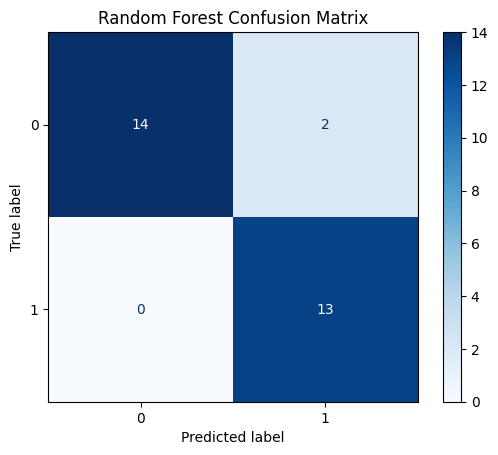

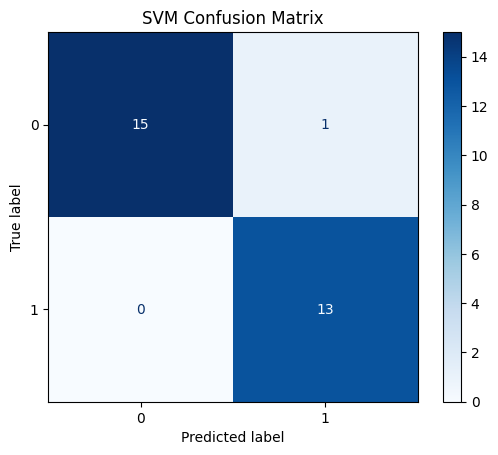

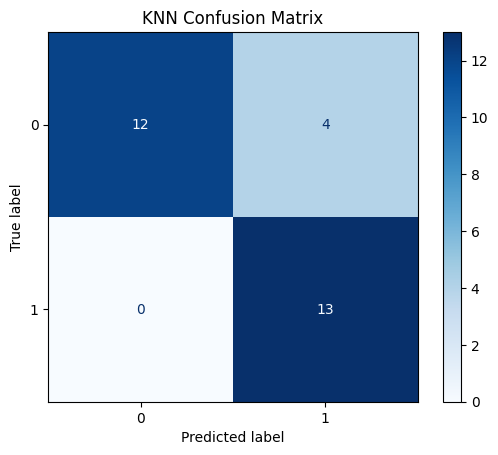

In [46]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")